# Data Modeling


In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report, log_loss, plot_confusion_matrix, roc_curve, auc, plot_roc_curve
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImPipeline
from sklearn.dummy import DummyClassifier

In [2]:
# Load cleaned dataframe

In [4]:
df = pd.read_csv(
'./Data/Cleaned_Terry_Stops.csv')

In [5]:
df.head()

,Unnamed: 0,Subject Age Group,Stop Resolution,Weapon Type,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Final Call Type,Arrest Flag,Frisk Flag
0,0,36 - 45,0,Unknown,White,Male,"DISTURBANCE, MISCELLANEOUS/OTHER",DISTURBANCE - OTHER,0,0
1,1,46 - 55,0,Unknown,White,Male,"SUSPICIOUS PERSON, VEHICLE OR INCIDENT",SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,0,0
2,2,26 - 35,0,No Weapons,White,Male,Unknown,Unknown,0,0
3,3,Unknown,0,Unknown,Black or African American,Male,SUSPICIOUS STOP - OFFICER INITIATED ONVIEW,SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,0,0
4,4,26 - 35,0,Unknown,Unknown,Female,"SUSPICIOUS PERSON, VEHICLE OR INCIDENT",SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,0,0


In [6]:
# Removed first column
df = df.drop(columns=['Unnamed: 0'])

In [7]:
df.shape

(2255432, 9)

In [8]:
# 2,255,432 rows are too huge. decease it to 250k rows

In [9]:
df = df.sample(n=250000, replace=False, weights=None, random_state=42)

# Model 1: Perform a Dummy Classifier Model.
# Features: Subject Age Group, Stop Resolution, Weapon Type, Subject Perceived Race, Gender, Initial Call Type, Final Call Type, Frisk Flag
1. Define X and y
2. Train Test Split
3. Preprocessing
4. Modeling
5. Predict, Evaluate

In [10]:
X = df.drop('Stop Resolution', axis = 1)
y = df['Stop Resolution']

In [11]:
# Do (60, 20, 20) data split

In [12]:
X_train_touch, X_test, y_train_touch, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_touch, y_train_touch, test_size = 0.25, random_state= 42)

In [13]:
# create a mini-pipelines into our ColumnTransformer: categorical

subpipe_cat = Pipeline(steps = [
    ('ohe', OneHotEncoder(sparse = False, handle_unknown = 'ignore'))
])

# Create a column transformer
# passthrough leaves the other df columns unchanged.

CT = ColumnTransformer( transformers = [
    ('subpipe_cat', subpipe_cat, selector(dtype_include = object))
], remainder = 'passthrough')

In [15]:
## BRING IN OUR CROSS VALIDATION MODELING CLASS FROM BEFORE, COPIED THE BELOW CODES FROM LECTURE PIPELINE

In [16]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

In [17]:
y.value_counts(normalize = True)

0    0.755328
1    0.244672
Name: Stop Resolution, dtype: float64

In [88]:
## Use SMOTE to balance the minority class

In [18]:
# Dummy model pipeline
dum_model_pipe = Pipeline(steps=[
    ('ct',CT),
    ('dum', DummyClassifier(strategy="most_frequent"))
])

In [19]:
dum_model_pipe.fit(X_train,y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff5a2f93400>)])),
                ('dum', DummyClassifier(strategy='most_frequent'))])

In [20]:
dum_model_pipe.score(X_train, y_train)

0.75658

In [21]:
dum_model_pipe.score(X_val, y_val)

0.75194

In [22]:
# perform cross-validation on the dummy model

<AxesSubplot:title={'center':'CV Results for `dum` Model'}>

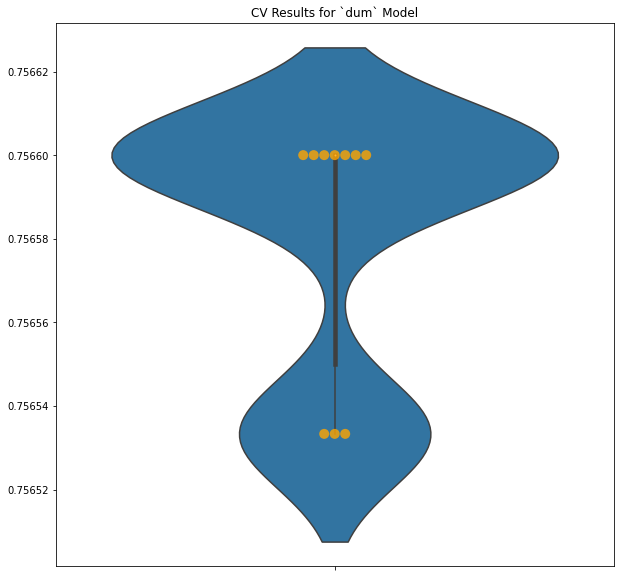

In [23]:
dum_pipe = ModelWithCV(
    dum_model_pipe,
    model_name='dum',
    X=X_train,
    y=y_train)
fix, ax = plt.subplots(figsize=(10,10))

dum_pipe.plot_cv(ax=ax)

In [24]:
dum_pipe.print_cv_summary()

CV Results for `dum` model:
            0.75658 ± 0.00003 accuracy
        


In [25]:
# Accuracy for traning set is 76% and 75% for validation set. With cross-validation is 76%

Dummy classifiers are mainly used for performance evaluation and can help to identify if a model is actually learning meaningful patterns or if the performance achieved is merely due to the class distribution in the dataset.

In [32]:
y_val_pred = dum_model_pipe.predict(X_val)

In [33]:
print (classification_report(y_val,y_val_pred))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86     37597
           1       0.00      0.00      0.00     12403

    accuracy                           0.75     50000
   macro avg       0.38      0.50      0.43     50000
weighted avg       0.57      0.75      0.65     50000



/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


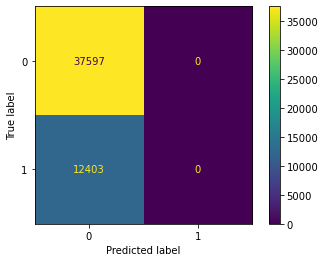

In [34]:
plot_confusion_matrix(dum_model_pipe, X_val,y_val)

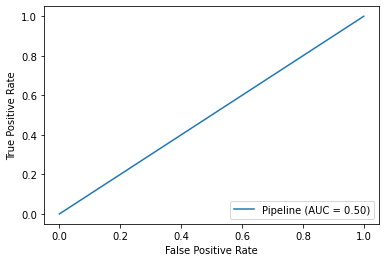

In [35]:
plot_roc_curve(dum_model_pipe, X_val,y_val)

# Model 2: First Logisitc Regression Model (FSM)

# Features: Subject Age Group, Weapon Type, Subject Perceived Race, Gender, Initial Call Type, Final Call Type, Frisk Flag, Arrest Flag

In [26]:
# Create FSM (First Simple Model)
## Use SMOTE to bring up the minority class to 33% (Minority), 66% (Majority)

logreg_model_pipe = ImPipeline(steps=[
    ('ct',CT),
    ('sm', SMOTE(sampling_strategy = 0.5, random_state = 42)), # setting minority half of majority
    ('fsm', LogisticRegression(random_state = 42))
])

In [27]:
logreg_model_pipe.fit(X_train, y_train) # this is taking a lot time because of OneHotEncoder and SMOTE

/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff5a2f93400>)])),
                ('sm', SMOTE(random_state=42, sampling_strategy=0.5)),
                ('fsm', LogisticRegression(random_state=42))])

/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

<AxesSubplot:title={'center':'CV Results for `FSM` Model'}>

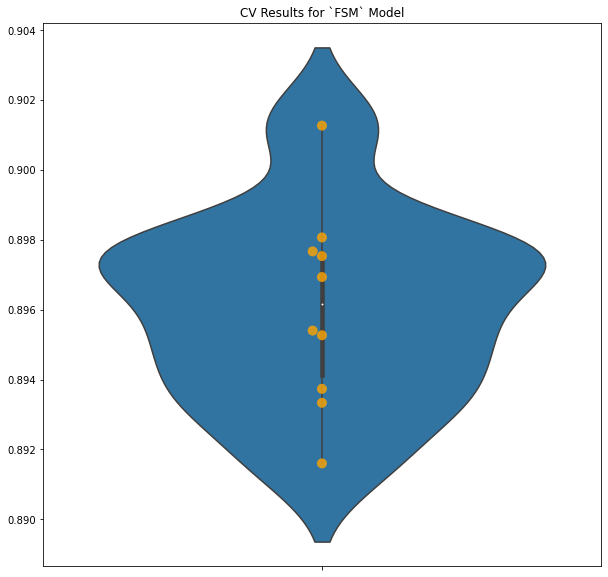

In [28]:
# Perform Cross-val on the training set with 10 folds
fsm_pipe = ModelWithCV(
    logreg_model_pipe,
    model_name='FSM',
    X=X_train,
    y=y_train)
fix, ax = plt.subplots(figsize=(10,10))

fsm_pipe.plot_cv(ax=ax)

In [89]:
fsm_pipe.print_cv_summary() # cross-validation training accuracy

CV Results for `FSM` model:
            0.89608 ± 0.00265 accuracy
        


In [30]:
logreg_model_pipe.score(X_val,y_val) # accuracy of the model with validation set

0.89624

## Observation: First logistic model has an accuracy of  89.6% on the training and 89.6% on the validation set. Very good and not over-fitting.

In [36]:
# Further investigation on the validation set, get a classification report

In [37]:
y_val_pred_fsm = logreg_model_pipe.predict(X_val)

In [38]:
print (classification_report(y_val,y_val_pred_fsm))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93     37597
           1       0.77      0.83      0.80     12403

    accuracy                           0.90     50000
   macro avg       0.86      0.88      0.86     50000
weighted avg       0.90      0.90      0.90     50000



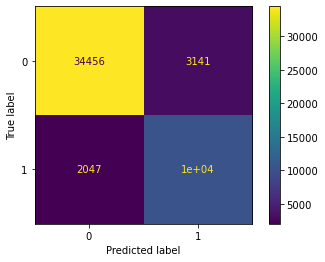

In [39]:
plot_confusion_matrix(logreg_model_pipe, X_val,y_val)

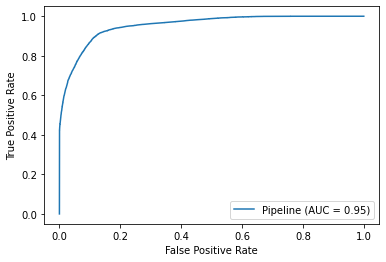

In [40]:
plot_roc_curve(logreg_model_pipe, X_val,y_val)

In [52]:
f1_score(y_val, y_val_pred_fsm)

0.7996911196911197

In [53]:
accuracy_score(y_val, y_val_pred_fsm)

0.89624

In [66]:
logreg_model_pipe.named_steps.fsm.coef_

array([[-4.31477668e-01, -1.26081300e-01,  7.02478693e-02,
         1.18788618e-02, -1.26935264e-01, -2.08420328e-01,
        -4.23306980e-01, -2.76772780e+00,  2.53600161e+00,
        -2.61307655e-01,  2.29798575e+00,  1.87200934e+00,
        -2.04369668e+00,  1.96660618e+00, -7.46481410e-01,
        -4.08748415e+00,  1.28250635e-01, -6.50766227e-02,
        -4.07484206e-02, -1.05395424e-01, -5.94264096e-01,
        -2.23575825e-01,  1.38584505e-01, -3.23254876e-01,
        -1.48614686e-01, -5.06957048e-01, -5.92408793e-02,
        -4.30477700e-01, -2.37419182e-01, -4.99020540e-01,
        -5.77861805e-01, -1.00502526e-02, -3.87357560e-01,
         8.37488189e-01, -2.35305047e-01,  5.22563055e-01,
        -5.71540255e-01, -4.03051217e-01, -3.19507720e-01,
        -6.32907711e-02,  3.72844219e-01,  9.85724439e-01,
         2.66642577e-01,  6.14620213e-01,  5.61405952e-01,
         8.65698637e-01,  7.17712090e-01, -1.57061048e+00,
         1.91582894e-01,  7.62779351e-01, -1.22842089e+0

## First logistic regression model has much better performance than the dummy model with an increase of 14.4% accuracy

   # Model 3: 1st Baseline Decision Tree Model

In [42]:
# Create FDT (First Decision Tree)
## Same pipeline. change the model to dt

base_dtc_pipe = ImPipeline(steps=[
    ('ct',CT),
    ('sm', SMOTE(sampling_strategy=0.5, random_state = 42)), # setting minority half of majority
    ('base_dtc', DecisionTreeClassifier(random_state = 42))
])

In [43]:
base_dtc_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff5a2f93400>)])),
                ('sm', SMOTE(random_state=42, sampling_strategy=0.5)),
                ('base_dtc', DecisionTreeClassifier(random_state=42))])

<AxesSubplot:title={'center':'CV Results for `base_dtc` Model'}>

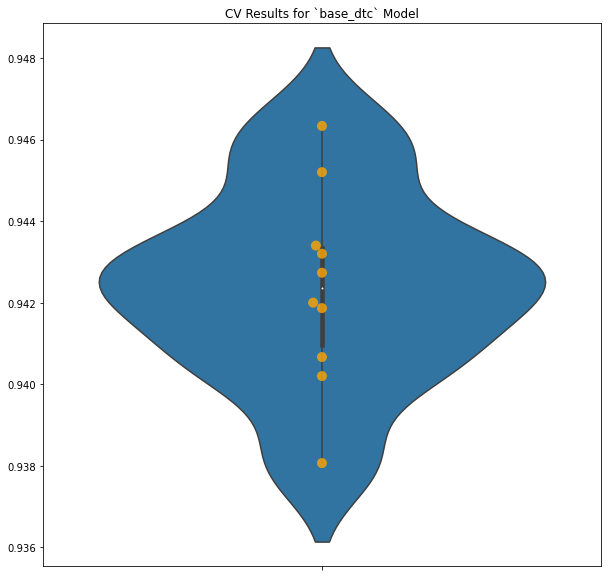

In [45]:
base_dtc = ModelWithCV(
    base_dtc_pipe,
    model_name='base_dtc',
    X=X_train,
    y=y_train)
fix, ax = plt.subplots(figsize=(10,10))

base_dtc.plot_cv(ax=ax)

In [46]:
base_dtc.print_cv_summary() # accuracy of the model on training set

CV Results for `base_dtc` model:
            0.94237 ± 0.00228 accuracy
        


In [47]:
base_dtc_pipe.score(X_val, y_val) # accuracy of the model on validation set

0.94502

In [48]:
y_val_pred_base_dtc = base_dtc_pipe.predict(X_val)

In [49]:
print (classification_report(y_val,y_val_pred_base_dtc)) # see how good the mdoel predict compared to validation targets

              precision    recall  f1-score   support

           0       0.96      0.97      0.96     37597
           1       0.89      0.88      0.89     12403

    accuracy                           0.95     50000
   macro avg       0.93      0.92      0.93     50000
weighted avg       0.94      0.95      0.94     50000



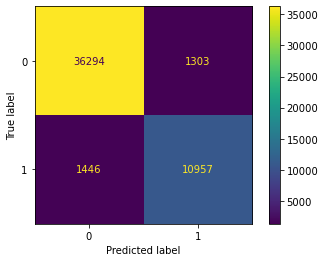

In [50]:
plot_confusion_matrix(base_dtc_pipe, X_val, y_val)

In [55]:
f1_score(y_val, y_val_pred_base_dtc)

0.8885374853018693

## Observation: comparing this model with first logreg, decision tree seems much better with f1-score being 0.89, and accuracy being 0.94 in both training and validation sets.


In [ ]:
## check ROC-AUC

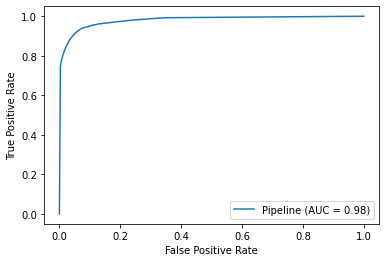

In [51]:
plot_roc_curve(base_dtc_pipe, X_val, y_val)

In [56]:
## AUC for this baseline decision tree classifier is pretty good. This baseline decision tree model is better.

In [63]:
base_dtc_pipe.named_steps.base_dtc.feature_importances_

array([4.25648739e-03, 9.08781501e-03, 9.68044541e-03, 8.38969763e-03,
       6.20606326e-03, 4.54232325e-03, 2.18852657e-03, 6.20676979e-04,
       2.76114413e-04, 0.00000000e+00, 1.76813655e-03, 3.00226292e-03,
       2.97250678e-04, 4.52250460e-03, 0.00000000e+00, 9.26516576e-02,
       4.36484766e-03, 4.24780067e-03, 1.13883759e-02, 4.84224826e-03,
       3.13061984e-03, 0.00000000e+00, 1.42097936e-03, 5.11323454e-03,
       1.06245940e-02, 6.88936923e-03, 0.00000000e+00, 7.35494911e-03,
       9.04419770e-04, 0.00000000e+00, 4.33242190e-05, 0.00000000e+00,
       0.00000000e+00, 4.05761424e-05, 8.14905260e-05, 0.00000000e+00,
       8.21905575e-04, 0.00000000e+00, 1.15613405e-04, 0.00000000e+00,
       1.01658257e-04, 9.51448216e-05, 0.00000000e+00, 7.32289587e-04,
       1.11020601e-04, 1.88807212e-04, 7.47361539e-04, 2.27715570e-03,
       2.60790162e-03, 3.33839074e-04, 5.54346899e-05, 1.13222960e-03,
       3.22207005e-04, 3.85439038e-04, 8.29031103e-05, 2.19906727e-04,
      

In [67]:
# trying gripsearch on decision tree

In [68]:

parameters = {'base_dtc__criterion': ['gini', 'entropy'],
          'base_dtc__min_samples_leaf': [10, 15, 20],
          'sm__k_neighbors': [9, 11, 13]}

gs = GridSearchCV(estimator= base_dtc_pipe,
                 param_grid=parameters,
                 cv=5,
                 verbose=2)

In [69]:
gs.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] base_dtc__criterion=gini, base_dtc__min_samples_leaf=10, sm__k_neighbors=9 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  base_dtc__criterion=gini, base_dtc__min_samples_leaf=10, sm__k_neighbors=9, total=15.2min
[CV] base_dtc__criterion=gini, base_dtc__min_samples_leaf=10, sm__k_neighbors=9 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 15.2min remaining:    0.0s


[CV]  base_dtc__criterion=gini, base_dtc__min_samples_leaf=10, sm__k_neighbors=9, total=16.1min
[CV] base_dtc__criterion=gini, base_dtc__min_samples_leaf=10, sm__k_neighbors=9 
[CV]  base_dtc__criterion=gini, base_dtc__min_samples_leaf=10, sm__k_neighbors=9, total=15.8min
[CV] base_dtc__criterion=gini, base_dtc__min_samples_leaf=10, sm__k_neighbors=9 
[CV]  base_dtc__criterion=gini, base_dtc__min_samples_leaf=10, sm__k_neighbors=9, total=26.3min
[CV] base_dtc__criterion=gini, base_dtc__min_samples_leaf=10, sm__k_neighbors=9 
[CV]  base_dtc__criterion=gini, base_dtc__min_samples_leaf=10, sm__k_neighbors=9, total=47.0min
[CV] base_dtc__criterion=gini, base_dtc__min_samples_leaf=10, sm__k_neighbors=11 
[CV]  base_dtc__criterion=gini, base_dtc__min_samples_leaf=10, sm__k_neighbors=11, total=61.0min
[CV] base_dtc__criterion=gini, base_dtc__min_samples_leaf=10, sm__k_neighbors=11 
[CV]  base_dtc__criterion=gini, base_dtc__min_samples_leaf=10, sm__k_neighbors=11, total=12.1min
[CV] base_dtc__

[CV]  base_dtc__criterion=entropy, base_dtc__min_samples_leaf=10, sm__k_neighbors=9, total=10.2min
[CV] base_dtc__criterion=entropy, base_dtc__min_samples_leaf=10, sm__k_neighbors=9 
[CV]  base_dtc__criterion=entropy, base_dtc__min_samples_leaf=10, sm__k_neighbors=9, total=10.3min
[CV] base_dtc__criterion=entropy, base_dtc__min_samples_leaf=10, sm__k_neighbors=9 
[CV]  base_dtc__criterion=entropy, base_dtc__min_samples_leaf=10, sm__k_neighbors=9, total=10.3min
[CV] base_dtc__criterion=entropy, base_dtc__min_samples_leaf=10, sm__k_neighbors=11 
[CV]  base_dtc__criterion=entropy, base_dtc__min_samples_leaf=10, sm__k_neighbors=11, total=10.9min
[CV] base_dtc__criterion=entropy, base_dtc__min_samples_leaf=10, sm__k_neighbors=11 
[CV]  base_dtc__criterion=entropy, base_dtc__min_samples_leaf=10, sm__k_neighbors=11, total=11.0min
[CV] base_dtc__criterion=entropy, base_dtc__min_samples_leaf=10, sm__k_neighbors=11 
[CV]  base_dtc__criterion=entropy, base_dtc__min_samples_leaf=10, sm__k_neighbor

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed: 1184.2min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_cat',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7ff5a2f93400>)])),
                                       ('sm',
                                        SMOTE(random_state=42,
                                              sampling_strategy=0.5)),
                                       ('base_dtc',
                      

In [71]:
gs.best_params_

{'base_dtc__criterion': 'entropy',
 'base_dtc__min_samples_leaf': 10,
 'sm__k_neighbors': 13}

In [72]:
gs.best_estimator_

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff46f6d4430>)])),
                ('sm',
                 SMOTE(k_neighbors=13, random_state=42, sampling_strategy=0.5)),
                ('base_dtc',
                 DecisionTreeClassifier(criterion='entropy',
                                        min_samples_leaf=10,
                                        random_state=42))])

In [73]:

# final_model = gs.best_estimator_


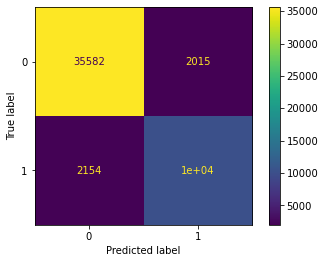

In [74]:
# plot_confusion_matrix(final_model, X_val, y_val)

In [75]:
# y_val_pred_best_dtc = final_model.predict(X_val)

In [76]:
# f1_score(y_val,y_val_pred_best_dtc)

0.8309887704220214

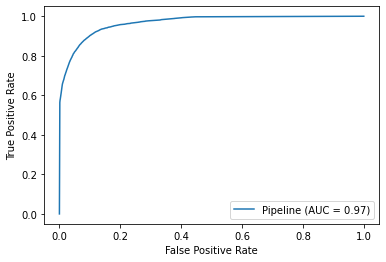

In [77]:
# plot_roc_curve(final_model, X_val, y_val)

In [78]:
# This final model doesn't look like it performance better than the 1st decision tree.

# Conclusion: Best model is base_dtc_pipe.

In [90]:
# Evaluate on test data.

In [79]:
y_test_hat = base_dtc_pipe.predict(X_test)

In [81]:
print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_test, y_test_hat), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_test, y_test_hat), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_test, y_test_hat), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_test, y_test_hat), 2)}.
""")


Our final model's accuracy on the test set is 0.94. 

Our final model's recall on the test set is 0.88 

Our final model's precision on the test set is 0.89 

Our final model's f1-score on the test is 0.89.



In [82]:
final_model = base_dtc_pipe

In [84]:
final_model.fit(X_train_touch,y_train_touch)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff5a2f93400>)])),
                ('sm', SMOTE(random_state=42, sampling_strategy=0.5)),
                ('base_dtc', DecisionTreeClassifier(random_state=42))])

In [85]:
final_model.score(X_train_touch,y_train_touch) 

0.951285

In [86]:
y_train_touch_pred = final_model.predict(X_train_touch)

In [87]:
f1_score(y_train_touch, y_train_touch_pred)

0.9008759703329907

## In conclusion my model has a f1_score 0.90 on the 80% training and validation set, and it also performs at a f1_score 0.89 on the testing set 20%. This decision tree classifier model is doing pretty good, not overfitting. F1 score is this project's matrix because it provides a balanced evaluation for the model to correctly classify both if an individual is going to be arrested or not. I strongly believe both the impact of false negative and false positive are significant in terms of arresting people, or assuming someone has committed a crime.